# Inference with CL-MAE

This notebook demonstrates the inference process using Deep Learning models pre-trained with self-supervised methods, specifically **contrastive learning** and **Masked Autoencoders (SparK)**, for medical imaging tasks.

The goal of this notebook is to:
- Load a pre-trained self-supervised model (e.g., ResNet50 with SparK, SwAV, MoCo, BYOL weights).
- Prepare medical image data for inference.
- Perform inference for classification.
- Visualize the results

#### DISCLAIMER
The code presented in this experiment was developed by the authors of this research, except for the pre-trained models and the NIH Chest X ray 14 dataset, used for fine-tuning.

For more details, see the original article: [Self-supervised pre-training with contrastive and masked autoencoder methods for dealing with small datasets in deep learning for medical imaging](https://www.nature.com/articles/s41598-023-46433-0).

>@article{wolf2023self,  
  title={Self-supervised pre-training with contrastive and masked autoencoder methods for dealing with small datasets in deep learning for medical imaging},  
  author={Wolf, Daniel and Payer, Tristan and Lisson, Catharina Silvia and Lisson, Christoph Gerhard and Beer, Meinrad and G{\"o}tz, Michael and Ropinski, Timo},  
  journal={Scientific Reports},  
  volume={13},  
  number={1},  
  pages={20260},  
  year={2023},  
  publisher={Nature Publishing Group UK London}  
}

For more details about the dataset see: [NIH Chest X ray 14 (224x224 resized)](https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/)

# Base Architecture
The study uses the **ResNet50** architecture as a base model to evaluate the different self-supervised pre-training methods. ResNet50 is a widely used deep Convolutional Neural Network known for its effectiveness in image classification tasks due to its skip connections architecture that helps mitigate the vanishing gradient problem in very deep networks.

# Self-supervised Pre-training Methods
- **Contrastive Learning**: Methods such as **SwAV**, **MoCo**, and **BYOL** learn representations by maximizing agreement between different views of the same image, while minimizing agreement with views of other images. They are widely used in natural images and adapted for the medical domain.
- **Masked Autoencoders (SparK)**: Inspired by the success of MAEs for Vision Transformers, **SparK** adapts the idea of ​​reconstructing masked parts of an image to CNNs using sparse convolutions. The model learns to predict the pixels of the masked regions, forcing it to learn rich contextual representations.

# Import Libraries

In [75]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from PIL import Image
import random
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix


seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

# Download Dataset

In [7]:
# Download latest version
path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jvoli\.cache\kagglehub\datasets\khanfashee\nih-chest-x-ray-14-224x224-resized\versions\3


# Custom Dataset Class

In [55]:
class ChestXrayDataset(Dataset):
    def __init__(self, csv_content, img_dir, transform=None):
        self.data = csv_content.copy()
        self.img_dir = img_dir
        self.transform = transform

        self.labels = sorted(set('|'.join(self.data["Finding Labels"]).split('|')))
        self.label2idx = {label: i for i, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Image Index"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Multi-hot encoding
        labels = torch.zeros(len(self.labels), dtype=torch.float32)
        for label in row["Finding Labels"].split("|"):
            if label in self.label2idx:
                labels[self.label2idx[label]] = 1.0

        return image, labels


# Create Dataloaders

In [56]:
def create_dataloaders(csv_path, images_path, batch_size):

    # Read full CSV
    df = pd.read_csv(csv_path)

    # Get a sample of 5% of the data
    df_sample = df.sample(frac=0.05, random_state=seed_value)

    train_df, val_df = train_test_split(df_sample, test_size=0.2, random_state=seed_value)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),      
        transforms.ToTensor(),              
        transforms.Normalize(               
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_dataset = ChestXrayDataset(train_df, images_path, transform=transform)
    val_dataset   = ChestXrayDataset(val_df, images_path, transform=transform)



    print("train_patients:", len(train_dataset))
    print("test_patients:", len(val_dataset))

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    }

    return dataloaders

In [57]:
dataloaders = create_dataloaders(
    csv_path=os.path.join(path, "Data_Entry_2017.csv"),
    images_path=os.path.join(path, "images-224/images-224"),
    batch_size=32
)

train_patients: 4484
test_patients: 1122


# Show Samples

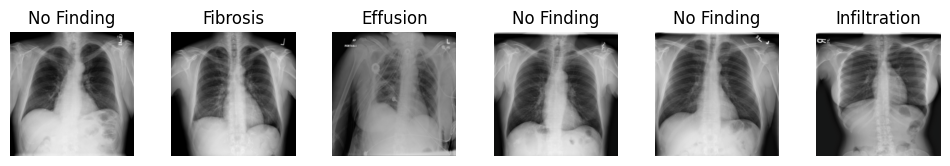

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

data_iter = iter(dataloaders['train'])

for i in range(6):
    inputs, labels = next(data_iter)
    input_img = inputs[0]
    class_label = labels[0] 

    inp = input_img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    axes[i].imshow(inp)
    
    class_idx = class_label.argmax().item()
    axes[i].set_title(class_names[class_idx])
    axes[i].axis('off')

plt.show()


# Validation Function

In [59]:
def evaluate(model, dataloaders, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_labels = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  
            loss = criterion(outputs, labels.float())

            running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels).item()
            total_labels += labels.numel()

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    epoch_loss = running_loss / len(dataloaders['val'].dataset)
    epoch_acc = running_corrects / total_labels  # acc/label

    return epoch_acc, all_labels, all_preds


# Train/Fine-Tune Function

In [60]:
def train(model, dataloaders, criterion, optimizer, scheduler, device, epochs=25):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc_history = []
    all_labels = []
    all_preds = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_labels = 0  

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset grads
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)                  
                preds = torch.sigmoid(outputs) > 0.5     
                loss = criterion(outputs, labels.float())  

                # Backward
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            
            
            running_corrects += torch.sum(preds == labels).item()
            total_labels += labels.numel()  

        scheduler.step()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / total_labels  # Acc/label

        val_acc, all_labels, all_preds = evaluate(model, dataloaders, criterion, device)
        acc_history.append(val_acc)
        
        best_warn = ""
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_warn = "BEST MODEL!"
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Acc: {val_acc:.4f} | {best_warn}")
        
    model.load_state_dict(best_model_wts)
    torch.save(model, './best_model.pt')
    return model, acc_history, all_labels, all_preds


# Loading Model
This function is an adaptation of the original code available at: https://github.com/Wolfda95/SSL-MedicalImagining-CL-MAE

In [61]:
    # Choose the Pre-Training Method here [options: "SparK", "SwAV", "MoCo", "BYOL"]
def get_model(pre_train, num_classes=15):

    match pre_train.lower():
        case "spark":
            pre_training_checkpoint = "SparK.pth"
        case "swav":
            pre_training_checkpoint = "SwAV.ckpt"
        case "moco":
            pre_training_checkpoint = "MoCoV2.ckpt"
        case "byol":
            pre_training_checkpoint = "BYOL.ckpt"
        case _:
            pre_training_checkpoint = None
    
    # PyTorch Resnet Model
    res_model = torchvision.models.resnet50()
    res_model.fc = torch.nn.Linear(res_model.fc.in_features, num_classes)


    if pre_training_checkpoint is None:
        return res_model

    # Load pre-training weights
    state_dict = torch.load(pre_training_checkpoint)

    # Match the correct name of the layers between pre-trained model and PyTorch ResNet
    # Extraction:
    if "module" in state_dict: # (SparK)
        state_dict = state_dict["module"] 
    if "state_dict" in state_dict: # (SwAV, MoCo, BYOL) 
        state_dict = state_dict["state_dict"]
    # Replacement: 
    if pre_train.lower() == "spark" or pre_train.lower() == "swav":
            state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}  
    elif pre_train.lower() == "moco":
        state_dict = {k.replace("encoder_q.", ""): v for k, v in state_dict.items()} 
    elif pre_train.lower() == "byol":
        state_dict = {k.replace("online_network.encoder.", ""): v for k, v in state_dict.items()}

    if 'fc.weight' in state_dict:
        del state_dict['fc.weight']
    if 'fc.bias' in state_dict:
        del state_dict['fc.bias']

    # Initialisation of the ResNet model with pre-training checkpoints
    res_model.load_state_dict(state_dict, strict=False)
        
    return res_model


In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = 15  # Number of classes in the dataset

models = {
    "resnet50_nopretrain": get_model('None', num_classes),
    "resnet50_spark": get_model("spark", num_classes),
    "resnet50_swav": get_model("swav", num_classes),
    "resnet50_moco": get_model("moco", num_classes),
    "resnet50_byol": get_model("byol", num_classes),
}

C:\Users\jvoli\AppData\Local\Temp\ipykernel_18136\1914292188.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pre_training_checkpoint)


In [63]:
best_models = {}
accuracies = {}
confusion_matrices = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

    # DEfine scheduler decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    model, acc_history, all_labels, all_preds     = train(model, dataloaders, criterion, optimizer, scheduler, device, epochs=5)
    best_models[model_name] = model
    accuracies[model_name] = acc_history
    confusion_matrices[model_name] = (all_preds, all_labels)

Tuning resnet50_nopretrain...
Epoch 1/5, Loss: 2.6610, Accuracy: 0.6179, Validation Acc: 0.5025 | BEST MODEL!
Epoch 2/5, Loss: 2.7000, Accuracy: 0.6227, Validation Acc: 0.6374 | BEST MODEL!
Epoch 3/5, Loss: 2.5807, Accuracy: 0.6129, Validation Acc: 0.5935 | 
Epoch 4/5, Loss: 2.5753, Accuracy: 0.6242, Validation Acc: 0.5061 | 
Epoch 5/5, Loss: 2.6602, Accuracy: 0.6169, Validation Acc: 0.6619 | BEST MODEL!
Tuning resnet50_spark...
Epoch 1/5, Loss: 2.4661, Accuracy: 0.6209, Validation Acc: 0.5885 | BEST MODEL!
Epoch 2/5, Loss: 2.3822, Accuracy: 0.5904, Validation Acc: 0.6063 | BEST MODEL!
Epoch 3/5, Loss: 2.3481, Accuracy: 0.5951, Validation Acc: 0.5982 | 
Epoch 4/5, Loss: 2.2995, Accuracy: 0.6013, Validation Acc: 0.6250 | BEST MODEL!
Epoch 5/5, Loss: 2.2779, Accuracy: 0.6004, Validation Acc: 0.5677 | 
Tuning resnet50_swav...
Epoch 1/5, Loss: 2.8315, Accuracy: 0.7525, Validation Acc: 0.7759 | BEST MODEL!
Epoch 2/5, Loss: 2.4910, Accuracy: 0.7760, Validation Acc: 0.7745 | 
Epoch 3/5, Loss:

In [ ]:
for model_name, model in models.items():
    if model_name != "resnet50_nopretrain":
        for name, param in model.named_parameters():
            if "layer1" in name or "layer2" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

In [65]:
best_models = {}
accuracies = {}
confusion_matrices = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

    # DEfine scheduler decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    model, acc_history, all_labels, all_preds     = train(model, dataloaders, criterion, optimizer, scheduler, device, epochs=5)
    best_models[model_name] = model
    accuracies[model_name] = acc_history
    confusion_matrices[model_name] = (all_preds, all_labels)

Tuning resnet50_nopretrain...
Epoch 1/5, Loss: 2.5108, Accuracy: 0.6275, Validation Acc: 0.6491 | BEST MODEL!
Epoch 2/5, Loss: 2.4618, Accuracy: 0.6101, Validation Acc: 0.5739 | 
Epoch 3/5, Loss: 2.4272, Accuracy: 0.6163, Validation Acc: 0.6553 | BEST MODEL!
Epoch 4/5, Loss: 2.4139, Accuracy: 0.6045, Validation Acc: 0.6259 | 
Epoch 5/5, Loss: 2.4130, Accuracy: 0.6253, Validation Acc: 0.5964 | 
Tuning resnet50_spark...
Epoch 1/5, Loss: 2.2486, Accuracy: 0.5897, Validation Acc: 0.6018 | BEST MODEL!
Epoch 2/5, Loss: 2.2297, Accuracy: 0.5962, Validation Acc: 0.5958 | 
Epoch 3/5, Loss: 2.2059, Accuracy: 0.5968, Validation Acc: 0.5715 | 
Epoch 4/5, Loss: 2.1663, Accuracy: 0.6001, Validation Acc: 0.5598 | 
Epoch 5/5, Loss: 2.1423, Accuracy: 0.6013, Validation Acc: 0.5574 | 
Tuning resnet50_swav...
Epoch 1/5, Loss: 2.4953, Accuracy: 0.7760, Validation Acc: 0.7736 | BEST MODEL!
Epoch 2/5, Loss: 2.4364, Accuracy: 0.7500, Validation Acc: 0.7212 | 
Epoch 3/5, Loss: 2.3968, Accuracy: 0.6811, Valida

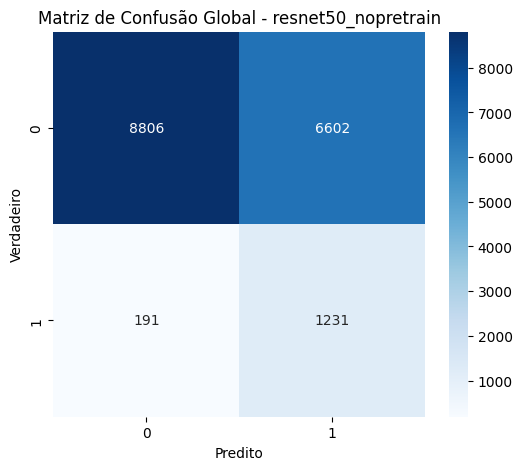

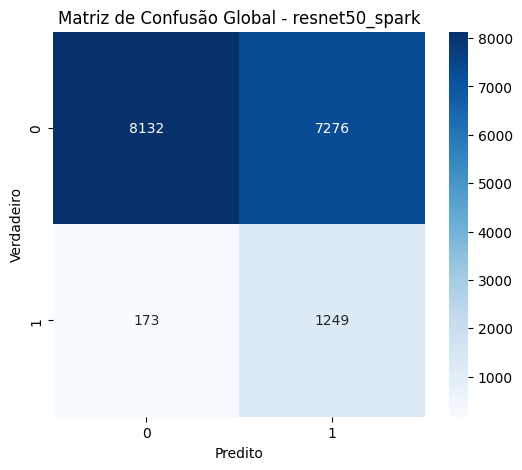

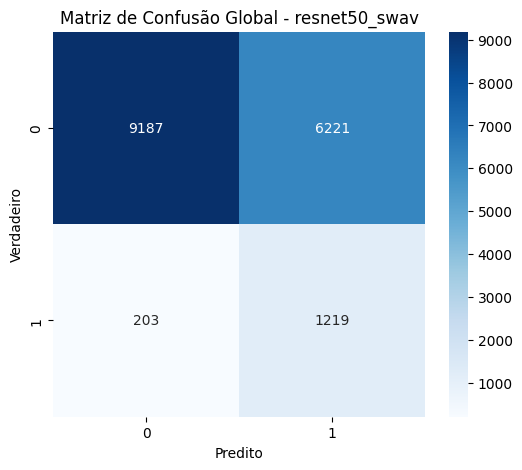

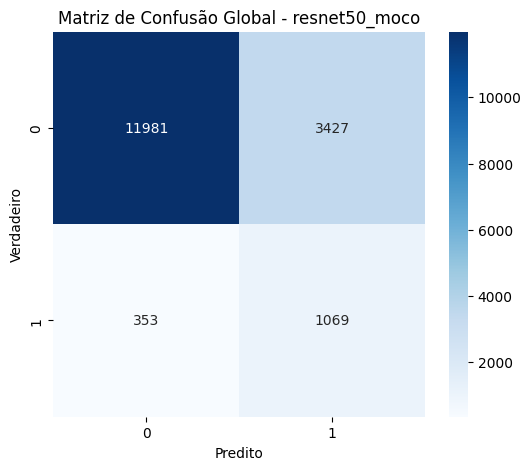

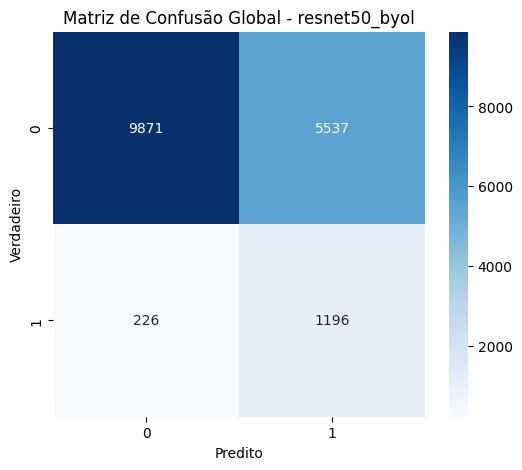

In [ ]:
def plot_confusion_matrix_global(preds_list, labels_list, model_name):
    # Concat
    preds = torch.cat(preds_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    if preds.dtype == torch.bool:
        preds = preds.int()
    if labels.dtype == torch.bool:
        labels = labels.int()
    
    preds = preds.flatten().numpy()
    labels = labels.flatten().numpy()
    
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.show()

for model_name, (preds_list, labels_list) in confusion_matrices.items():
    plot_confusion_matrix_global(preds_list, labels_list, model_name)


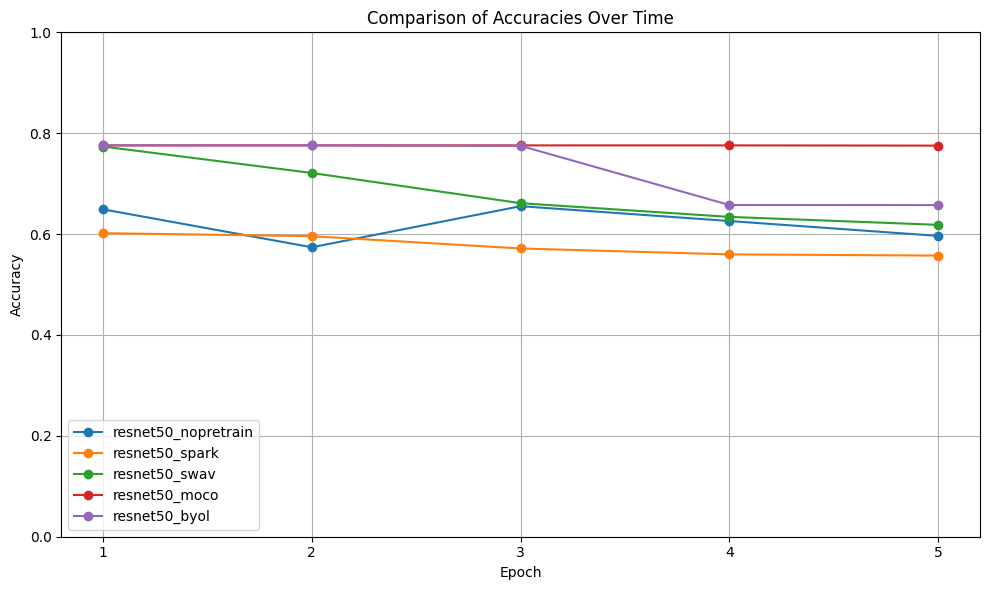

In [ ]:
# Epochs for x-axis
epochs = list(range(1, len(next(iter(accuracies.values()))) + 1))

plt.figure(figsize=(10, 6))

# Plot
for model_name, acc in accuracies.items():
    plt.plot(epochs, acc, marker='o', label=model_name)


plt.title("Comparison of Accuracies Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()